In [1]:
import pandas as pd
import numpy as np
import torch  
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import classification_report  
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

/root/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置随机种子，确保可复现性
torch.manual_seed(10)
np.random.seed(10)

# 如果你使用CUDA，也要设置CUDA的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(10)

In [3]:
# 加载数据集
# train_df =  pd.read_csv('../KDDTrain_SMOTE.csv')
train_df =  pd.read_csv('KDDTrain_CGAN_DCNN_selfatten_30test1.csv')
# train_df = pd.read_csv('./数据/KDDTrain+afterP.csv')
test_df = pd.read_csv('./数据/KDDTest+afterP.csv')

In [4]:
# 划分训练集和测试集的标签和特征
y_train = train_df['attack_type']
X_train = train_df.drop(columns = ['attack_type'])
y_test = test_df['attack_type']
X_test = test_df.drop(columns = ['attack_type'])

In [5]:
train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,0.000000,491.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
1,0.000000,146.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.000000,232.000000,8153.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
4,0.000000,199.000000,420.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336710,0.267503,2.005839,0.774193,0.089133,-0.373058,0.157678,0.741647,0.135701,-0.464485,0.318768,...,0.402442,0.330927,-0.150762,1.195050,-0.152369,-0.359481,0.393036,1.007670,-0.945652,0
336711,0.293904,2.022856,0.795366,0.086737,-0.368089,0.192369,0.752375,0.139976,-0.467858,0.316102,...,0.419304,0.310448,-0.156021,1.201499,-0.156363,-0.376847,0.408070,1.014581,-0.956872,0
336712,0.286433,2.019063,0.790259,0.087298,-0.369799,0.181375,0.749350,0.138650,-0.466751,0.317188,...,0.414731,0.316768,-0.153890,1.199571,-0.155039,-0.371447,0.403726,1.012512,-0.953219,0
336713,0.275541,1.989577,0.775843,0.073823,-0.377149,0.170672,0.720711,0.130505,-0.455509,0.311683,...,0.390128,0.326518,-0.151631,1.179050,-0.151227,-0.346936,0.406453,0.991125,-0.943027,0


In [6]:
scaler = StandardScaler()
# 使用训练集数据拟合scaler  
X_train = scaler.fit_transform(X_train)
# 使用相同的scaler转换测试集数据，使用训练集上拟合的scaler；这是为了防止数据泄露，并确保测试集或验证集的特征转换与训练集一致
X_test = scaler.transform(X_test)

In [7]:
# 需要把类别特征进行数值化：['dos','normal','probe','r2l','u2r']分别映射为0 1 2 3 4
from sklearn.preprocessing import LabelEncoder  
# 初始化LabelEncoder  
le = LabelEncoder()  

# 对y_train中的类别特征进行数值化  
y_train_encoded = le.fit_transform(y_train)

# 对y_test中的类别特征进行数值化
y_test_encoded = le.fit_transform(y_test)

# 将数据转换为PyTorch张量格式,才能进行后续的运算 （需要Numpy格式进行转换）
X_train = torch.tensor(X_train, dtype=torch.float32)  
y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long)  
X_test = torch.tensor(X_test, dtype=torch.float32)  
y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long) 

# # 使用one_hot函数将类别数字转换为独热编码, 代价敏感需要输入标签最好是进行了独热编码  
# y_train_encoded = F.one_hot(y_train_encoded, num_classes=5) 

In [8]:
# 创建数据加载器  
train_dataset = TensorDataset(X_train, y_train_encoded)  
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)  

test_dataset = TensorDataset(X_test, y_test_encoded)  
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [11]:
# 在CPU上跑CNN实在太慢，需要使用NVIDA GPU
# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# # 将模型移动到GPU上
# autoencoder = autoencoder.to(device)
# 将数据移动到GPU上
X_train = X_train.to(device)
y_train_encoded = y_train_encoded.to(device)
X_test = X_test.to(device)
y_test_encoded = y_test_encoded.to(device)

In [12]:
X_train

tensor([[-0.0668, -0.0046, -0.0030,  ...,  0.6705,  1.3011,  1.1622],
        [-0.0668, -0.0047, -0.0030,  ...,  0.6705,  1.3011,  1.1622],
        [-0.0668, -0.0047, -0.0030,  ...,  0.6705, -1.3508,  1.1622],
        ...,
        [-0.0666, -0.0047, -0.0030,  ...,  1.2208,  1.3343, -2.2365],
        [-0.0666, -0.0047, -0.0030,  ...,  1.2246,  1.2776, -2.2002],
        [-0.0666, -0.0047, -0.0030,  ...,  1.2132,  1.3295, -2.2227]],
       device='cuda:0')

In [13]:
# 通道注意力（卷积块注意力的子模块，修改应用于一维特征的提取过程）
# 输入[batch size, channel, feature] 输出通道注意力权重
class ChannelAttention(nn.Module):  
    def __init__(self, in_planes, ratio=8):  #in_planes输入通道数； ratio通道数压缩比例
        super(ChannelAttention, self).__init__()  
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1) # 自适应平均池化，根据给定的参数作为输出
        self.max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        # 用1x1卷积 进行重构【batchsize，channel，1】维度的池化结果； 先降低通道数in_planes // ratio，再提升通道数
        self.fc1 = nn.Conv1d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv1d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, x):
        x1 = self.avg_pool(x)
        x1 = self.fc1(x1) # 压缩通道数
        x1 = self.relu1(x1)
        avg_out = self.fc2(x1) # 提升通道数
        
        x2 = self.max_pool(x)
        x2 = self.fc1(x2)
        x2 = self.relu1(x2)
        max_out = self.fc2(x2)
        
        out = avg_out + max_out
        return self.sigmoid(out)

In [14]:
# 空间注意力（卷积块注意力的子模块，修改应用于一维特征的提取过程）
# 输入[batch size, channel, feature] 输出空间注意力权重（和通道注意力是另一个方向，跨通道同一个位置的池化）
class SpatialAttention(nn.Module):  
    def __init__(self, in_feature, ratio=5):  #in_planes输入通道数； ratio通道数压缩比例
        super(SpatialAttention, self).__init__()  
        # 用1x1卷积 进行重构【batchsize，channel，1】维度的池化结果； 先降低通道数in_planes // ratio，再提升通道数
        self.fc1 = nn.Linear(in_feature, in_feature // ratio, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_feature // ratio, in_feature, bias=False)
        self.sigmoid = nn.Sigmoid()
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, x):
        # 全局平均池化,对跨通道的维度进行平均
        x1 = torch.mean(x, dim=1, keepdim=True)
        x1 = self.fc1(x1) # 压缩
        x1 = self.relu1(x1)
        avg_out = self.fc2(x1) # 提升
        
        # 全局最大池化,对跨通道的维度进行最大
        x2,_ = torch.max(x, dim=1, keepdim=True)
        x2 = self.fc1(x2) 
        x2 = self.relu1(x2)
        max_out = self.fc2(x2)
        # print(max_out.shape)
        
        out = avg_out + max_out
        # print(out.shape) 128 1 40
        return self.sigmoid(out)

In [15]:
# 定义CNN
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN, self).__init__()
        self.fc_r = nn.Linear(input_dim,hidden_dim)
        init.xavier_uniform_(self.fc_r.weight)  # 使用Xavier均匀分布初始化权重
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.ca1 = ChannelAttention(16)
        self.ca2 = ChannelAttention(32)
        self.ca3 = ChannelAttention(64)
        self.ca4 = ChannelAttention(128)
        # self.sa1 = SpatialAttention(40)
        # self.sa2 = SpatialAttention(40)
        # self.sa3 = SpatialAttention(20)
        # self.sa4 = SpatialAttention(20)
        
        self.ln1 = nn.LayerNorm(normalized_shape=[40])
        self.ln2 = nn.LayerNorm(normalized_shape=[20])
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 10, output_dim)
        
        init.xavier_uniform_(self.conv1.weight)
        init.xavier_uniform_(self.conv2.weight)
        init.xavier_uniform_(self.conv3.weight)
        init.xavier_uniform_(self.conv4.weight)
        init.xavier_uniform_(self.fc.weight)
  
    def forward(self, x): 
        x = self.fc_r(x)
        x = x.unsqueeze(1)  # 增加通道维度  b 1 60
        x = self.conv1(x)  # b 16 60
        x = self.ca1(x) * x
        # x = self.sa1(x) * x
        x = self.ln1(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        
        x = self.conv2(x)  # b 32 60
        x = self.ca2(x) * x
        # x = self.sa2(x) * x
        x = self.ln1(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        
        x = self.maxpool(x) 
        
        x = self.conv3(x)  # b 64 30
        x = self.ca3(x) * x
        # x = self.sa3(x) * x
        x = self.ln2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        
        x = self.conv4(x)  # b 128 30
        x = self.ca4(x) * x
        # x = self.sa4(x) * x
        x = self.ln2(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        
        x = self.maxpool(x)
        
        x = self.flatten(x)  # b 128x15
        x = self.fc(x)  # b 5
        x = F.softmax(x)
        return x

In [16]:
input_dim = 123 # 特征维度
hidden_dim = 40 # 隐藏层维度
output_dim = 5 # 分类数量
# 实例化综合集成模型
model = CNN(input_dim, hidden_dim, output_dim)

In [17]:
train_loss_all = []

In [18]:
class_counts = {'normal': 67343, 'dos': 45927, 'probe': 11656, 'r2l': 995, 'u2r': 52}
total_samples = sum(class_counts.values())
  
# 计算每个类别的样本数量倒数，作为初始代价
initial_costs = {cls: total_samples / count for cls, count in class_counts.items()}

# 归一化代价，使得最大代价为某个值（比如1000），以便调整代价矩阵的范围
max_cost = max(initial_costs.values())
normalized_costs = {cls: cost / max_cost * 1000 for cls, cost in initial_costs.items()}

# 创建代价矩阵，对角线上为0（表示正确分类），其余为归一化后的代价
cost_matrix = torch.zeros(len(class_counts), len(class_counts))
for i, cls1 in enumerate(class_counts.keys()):
    for j, cls2 in enumerate(class_counts.keys()):
        if i != j:  # 不是对角线元素
            cost_matrix[i, j] = normalized_costs[cls1]
        # if i == 4 and j != 4:
        #     cost_matrix[i,j] = 50
        # if i == 3 and j != 3:
        #     cost_matrix[i,j] = 21.1306
print(cost_matrix)
cost_matrix = cost_matrix.to(device)

tensor([[0.0000e+00, 7.7217e-01, 7.7217e-01, 7.7217e-01, 7.7217e-01],
        [1.1322e+00, 0.0000e+00, 1.1322e+00, 1.1322e+00, 1.1322e+00],
        [4.4612e+00, 4.4612e+00, 0.0000e+00, 4.4612e+00, 4.4612e+00],
        [5.2261e+01, 5.2261e+01, 5.2261e+01, 0.0000e+00, 5.2261e+01],
        [1.0000e+03, 1.0000e+03, 1.0000e+03, 1.0000e+03, 0.0000e+00]])


In [129]:
# !pip install seaborn --user

In [130]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1.5)
# plt.rc('font',family='Times New Roman',size=12)
# classes = [ 'Normal','DoS', 'Probe', 'R2L', 'U2R'] 
# # 绘制热力图
# plt.figure(figsize=(12, 10))  # 设置图形大小
# # OrRd YlGnBu  greys greens Purples rainbow  gist_rainbow
# sns.heatmap(cost_matrix, annot=True, cmap='YlGnBu', xticklabels=classes, yticklabels=classes)  # annot=True 显示数字，cmap设置颜色映射
# plt.xlabel('Predicted Labels')  # x轴标签
# plt.ylabel('Truth Labels')  # y轴标签
# plt.title('Cost Weight Matrix')  # 标题
# plt.show()

In [19]:
# 代价敏感交叉熵损失
class CostSensitiveCrossEntropyLoss(nn.Module):
    def __init__(self, cost_matrix, reduction='mean'):
        super(CostSensitiveCrossEntropyLoss, self).__init__()
        self.cost_matrix = cost_matrix # 代价矩阵
        self.reduction = reduction # 规约方式
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets):
        ce_losses = self.ce_loss(outputs, targets)
        # print(ce_losses) # 128个样本各自的损失
        
        # 直接使用targets中的类别索引从cost_matrix中选择对应的行（真实的）
        # 使用outputs作为列索引（预测的）
        cost_values = self.cost_matrix[targets, outputs.argmax(dim=-1)]
        # print(cost_values)  #  torch.Size([128]) 
        # print(outputs.argmax(dim=-1)) 
        
        weighted_losses = cost_values * ce_losses# 逐元素加权
        if self.reduction == 'mean':
            return weighted_losses.mean()
        elif self.reduction == 'sum':
            return weighted_losses.sum()
        else:
            return weighted_losses

In [20]:
# criterion = nn.CrossEntropyLoss() # 在交叉熵nn.CrossEntropy中已经内置了Softmax
cs_criterion = CostSensitiveCrossEntropyLoss(cost_matrix)
# cs_criterion = AdjustCostSensitiveCE(initial_cost_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
model = model.to(device)

In [36]:
# from thop import profile
# from thop import clever_format
# x = torch.randn(1,1,123)
# x = x.to(device)
# model = model.to(device)
# flops, params = profile(model, inputs=x)
# flops, params = clever_format([flops, params], '%.5f')

# print('Network Parameters：',params)
# print('FLOPs per sample：',flops)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.AdaptiveMaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
Network Parameters： 51.06900K
FLOPs per sample： 732.20000K


In [151]:
# new CBNCVAE 7062
# new CVAEbl 0.7881    0.7576    0.7138
# GAN bl standard 
# CGAN SA DCNN 30lun 0.7512    0.7543    0.7082
# CGAN SA DCNN standard 0.8300    0.8050    0.7806
# 0.7574    0.7612    0.7161 100不平衡
#  0.8247    0.8111    0.7976SMOTE

# 训练模型
num_epochs = 20
accumulation_steps = 1
model = model.to(device)
model.train()
train_loss_this = []
for epoch in range(num_epochs):
    train_loss_add = 0
    for i,(inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = cs_criterion(outputs, labels)
        train_loss_add += loss.item()
        loss.backward()
        if ((i+1)%accumulation_steps)==0:
            # 优化
            optimizer.step()
            optimizer.zero_grad()
    scheduler.step()
    lr = scheduler.get_last_lr()[0]  # 获取最后一个学习率
    # train_loss = train_loss_add/len(train_loader.dataset)
    # train_loss_this.append(train_loss)
     # 打印每个epoch的平均损失和最后的学习率
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_add:.7f}, lr:{lr:.7f}')
    
    y_pred_list = []
    y_test_list = []
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)  # 前向传播
        y_pred_part = torch.argmax(outputs, dim=1)  # 获取预测标签
        y_pred_list.extend(y_pred_part.cpu().numpy())  # 添加到列表中
        y_test_list.extend(labels.cpu().numpy())  # 添加真实标签到列表中，用于计算F1分数
    # 将预测标签和真实标签转换为numpy数组
    y_pred = np.array(y_pred_list)
    y_test = np.array(y_test_list)
    # 计算F1分数
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Current F1 score: {f1}")
    if f1 > 0.83:
        break

Epoch [1/20], Loss: 723.8181765, lr:0.0085000
Current F1 score: 0.6872278824829849
Epoch [2/20], Loss: 352.1731111, lr:0.0072250
Current F1 score: 0.7310856660619933
Epoch [3/20], Loss: 302.4253960, lr:0.0061413
Current F1 score: 0.7255996010530237
Epoch [4/20], Loss: 201.7418330, lr:0.0052201
Current F1 score: 0.7460239582192892
Epoch [5/20], Loss: 166.1419591, lr:0.0044371
Current F1 score: 0.7538045317324251
Epoch [6/20], Loss: 159.9238288, lr:0.0037715
Current F1 score: 0.7903016196150684
Epoch [7/20], Loss: 110.3992594, lr:0.0032058
Current F1 score: 0.7228608994844321
Epoch [8/20], Loss: 116.3130689, lr:0.0027249
Current F1 score: 0.7767270796027311
Epoch [9/20], Loss: 99.0556178, lr:0.0023162
Current F1 score: 0.7544033183879626
Epoch [10/20], Loss: 88.5365240, lr:0.0019687
Current F1 score: 0.7958644745850436
Epoch [11/20], Loss: 75.4780952, lr:0.0016734
Current F1 score: 0.7769749404191664
Epoch [12/20], Loss: 64.0783919, lr:0.0014224
Current F1 score: 0.7634646434985211
Epoch

In [262]:
# # 假设 model 已经被训练好了  
# # 获取模型参数  
# model_parameters = model.state_dict()  
# # 选择一个保存模型参数的文件路径  
# save_path = '代敏+4通注8373cnn_para_0.01_.pth'  
# # 使用 torch.save() 函数保存模型参数  
# torch.save(model_parameters, save_path)  
# # 打印保存成功的消息  
# print(f"model parameters have been saved to {save_path}")

model parameters have been saved to 代敏+4通注8373cnn_para_0.01_0.85.pth


In [35]:
############加载模型
# 选择一个加载模型参数的文件路径
load_path ='代敏+4通注8451cnn_para_0.01_0.85.pth'
# 使用 torch.load() 函数加载模型参数
loaded_parameters = torch.load(load_path)
# 加载模型参数到模型中
model.load_state_dict(loaded_parameters)
# 打印加载成功的消息  
print(f"model parameters have been loaded from {load_path}")

model parameters have been loaded from 代敏+4通注8451cnn_para_0.01_0.85.pth


In [76]:
model = model.to(device)
for i,(inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device) 
    with torch.no_grad():  # 禁止梯度的计算
        outputs = model(inputs)  # 前向传播
        # print(outputs)
        # print(outputs.shape)
        # 进行预测  
        # 获取每个样本的预测标签 
        y_pred_part = torch.argmax(outputs, dim=1)  # 原始输出的类别分数，找到最大值的索引作为预测标签
        if i == 0:
            y_pred = y_pred_part
        else:
            y_pred = torch.cat((y_pred, y_pred_part), dim=0)
        if i % 100 == 0:
            print(y_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0, 0, 3, 2, 2, 1, 1, 1, 1, 3, 3, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 0, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 1, 0, 0], device='cuda:0')
tensor([0, 0, 3,  ..., 0, 1, 3], device='cuda:0')
tensor([0, 0, 3,  ..., 1, 1, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 0, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 3, 0], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 1, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 0, 1, 3], device='cuda:0')
tensor([0, 0, 3,  ..., 1, 1, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 1, 0], device='cuda:0')
tensor([0, 0, 3,  ..., 2, 1, 0], device='cuda:0')
tensor([0, 0, 3,  ..., 1, 1, 0], device='cuda:0')
tensor([0, 0, 3,  ..., 1, 1, 1], device='cuda:0')
tensor([0, 0, 3,  ..., 0, 1, 1], device='cuda:0')


In [77]:
# 将Tensor格式转换为numpy
y_pred = y_pred.cpu()
y_pred = y_pred.numpy()
# y_test_encoded = y_test_encoded.cpu()
# y_test_encoded = y_test_encoded.numpy()

In [153]:
from sklearn.metrics import classification_report
# 分别打印各个类别的P、R和F1
labels = ['dos','normal','probe','r2l','u2r']
# 0.6406    0.6589    0.6093
# 0.6333    0.6604    0.6119
# 单纯代价敏感 8009 8016 8017 0.01 0.85 20
# 代价敏感 4个通道注意力 0.01 0.85 20：0.8390    0.8189    0.8112
# 代价敏感 4个通道注意力 0.01 0.85 25：0.8462    0.8257    0.8206/0.8472    0.8274    0.8221
print(classification_report(y_test_encoded, y_pred, target_names=labels,digits = 4))

              precision    recall  f1-score   support

         dos     0.9609    0.8036    0.8752      7636
      normal     0.8793    0.9194    0.8989      9711
       probe     0.6014    0.8938    0.7191      2421
         r2l     0.7657    0.7116    0.7376      2576
         u2r     0.0769    0.0050    0.0094       200

    accuracy                         0.8455     22544
   macro avg     0.6568    0.6667    0.6480     22544
weighted avg     0.8570    0.8455    0.8452     22544



In [102]:
# !pip install seaborn

In [260]:
# 尝试打印混淆矩阵
Confusion_matrix = confusion_matrix(y_test_encoded, y_pred)
print(Confusion_matrix)

[[6074 1092  286  176    8]
 [  68 9207  374   61    1]
 [ 179  136 2059   43    4]
 [   3  795  149 1617   12]
 [   0   65   53   71   11]]


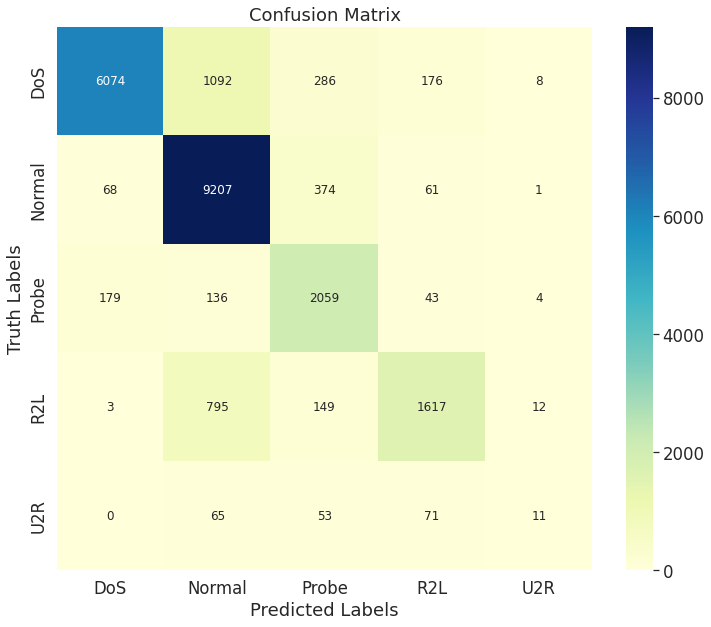

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rc('font',family='Times New Roman',size=12)
classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R'] 
# 绘制热力图
plt.figure(figsize=(12, 10))  # 设置图形大小
# OrRd YlGnBu  greys greens Purples rainbow  gist_rainbow
sns.heatmap(Confusion_matrix, annot=True, cmap='YlGnBu', fmt="d",xticklabels=classes, yticklabels=classes)  # annot=True 显示数字，cmap设置颜色映射
plt.xlabel('Predicted Labels')  # x轴标签
plt.ylabel('Truth Labels')  # y轴标签
plt.title('Confusion Matrix')  # 标题
plt.show()